# World CO2 Emissions Forecasting
## Fitting a LSTM Model (Recurrent Neural Network)
[*Cristian Castro Álvarez*](https://github.com/cristian-castro-a)

**Goal**: 
- To fit a LSTM RNN Model to the World CO2 Emissions data


**Data:**
- The data comes from [Our World in Data](https://github.com/owid/co2-data)
- Column 'CO2' of the dataframe indicates the Tonnes of CO2 emmitted into the atmosphere.
- The dataset includes yearly data from 1750 to 2020, with a total of 271 data points.

In [1]:
# Libraries
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objects as go

import tensorflow as tf
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
import os

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

# The World CO2 Emissions Data

In [2]:
df = pd.read_csv('../Data/owid-co2-data.csv')
df.head()

,iso_code,country,year,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,0.002,NaN,NaN,NaN,0.015,0.002,...,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,0.011,NaN,NaN,NaN,0.021,0.003,...,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,0.012,NaN,NaN,NaN,0.026,0.003,...,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,0.012,NaN,NaN,NaN,0.032,0.004,...,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001732e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,0.013,NaN,NaN,NaN,0.038,0.005,...,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


In [3]:
# Aggregate the data on a yearly basis (the entire world as one entity, I don't care about the emissions of individual countries)
df = df.groupby(by=['year']).sum().reset_index()[['year','co2']]
df.insert(loc = 1, column = 'month', value = 12)
df.insert(loc = 2, column = 'day', value = 31)
values = pd.to_datetime(df[['year','month','day']])
df.insert(loc = 0, column = 'date', value = values)
df.drop(['year','month','day'], axis = 1, inplace = True)
df.head()

,date,co2
0,1750-12-31,46.755
1,1751-12-31,46.755
2,1752-12-31,46.770
3,1753-12-31,46.770
4,1754-12-31,46.790


In [4]:
# To work with tonnes of CO2 it is necessary a conversion factor of 3.664
df['co2'] = df['co2']/3.664
df.tail().round(1)

,date,co2
266,2016-12-31,34035.4
267,2017-12-31,34471.8
268,2018-12-31,35058.0
269,2019-12-31,35049.9
270,2020-12-31,33185.8


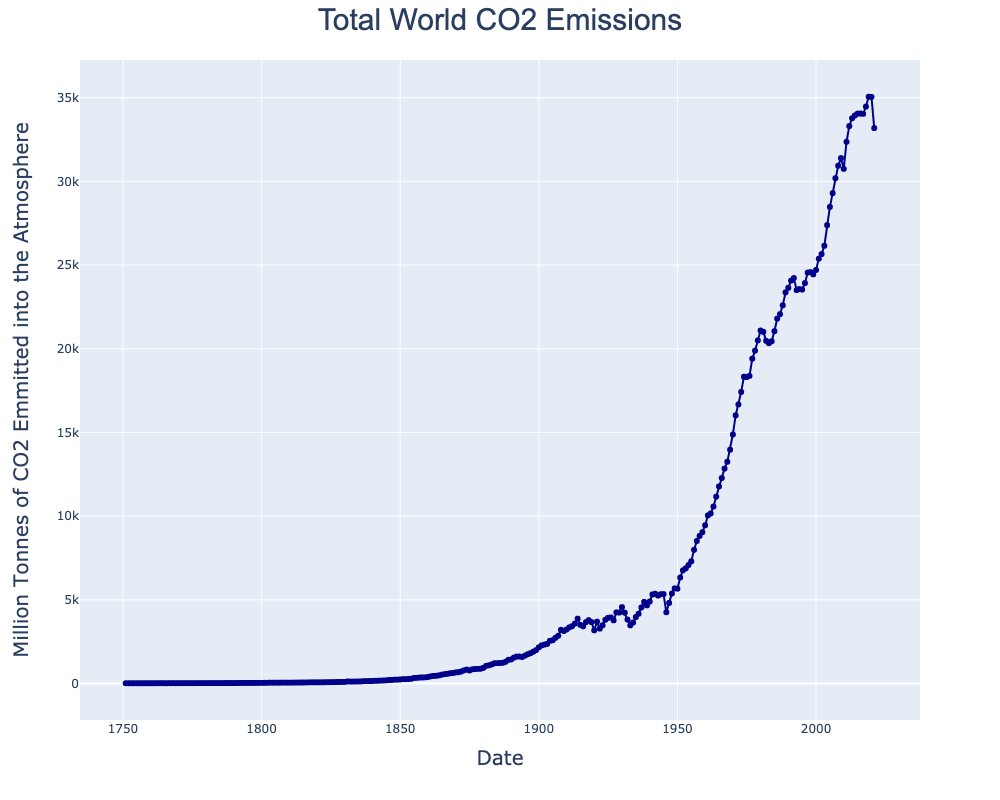

In [5]:
# Visualizing the world emissions per year
fig = px.line(df, 
                x = 'date', 
                y = 'co2', 
                markers = True, 
                height = 800, 
                width = 1000)

fig.update_layout(title = dict(
        text = 'Total World CO2 Emissions',
        font = dict(
            family = 'Arial',
            size = 30
        ),
        x = 0.5
    )
    )

fig.update_traces(line_color = 'darkblue')

fig.update_xaxes(
    title_text = 'Date',
    title_font = {'size': 20}
)

fig.update_yaxes(
    title_text = 'Million Tonnes of CO2 Emmitted into the Atmosphere',
    title_font = {'size': 20}
)

fig.show('png')

**Comments:**
- The time series shows worrying trend about CO2 Emissions
- The last point shows an abrupt drop in the CO2 Emissions, this points corresponds to the COVID-19 pandemic effect

# Preprocessing the Data for a LSTM Model

- We are going to input multiple sequences of data (fixed length time series) to train the LSTM Recurrent Neural Network
- These sequences must be the same length, throughout the training period
- Therefore we will create a windowing function, that will create sequences of fixed length to be used as inputs for our model

## Windowing Function

In [6]:
def df_to_inputs(df, window_size = 5):
    # Input: dataframe with the time series and window size
    # Windows size refers to the number of points in the series with which the model will be trained
    # Output: X, y for training
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        X.append([[a] for a in df_as_np[i:i+5]])
        y.append(df_as_np[i+5])
    return np.array(X), np.array(y)

In [7]:
# Getting the windows
WINDOW_SIZE = 5
X, y = df_to_inputs(df['co2'], WINDOW_SIZE)

In [8]:
X.shape, y.shape

((266, 5, 1), (266,))

## Scaling and Splitting for Train, Validation and Test Sets
- We are going to use 92.5% of the data for training (train and validation) and 7.5% for testing
- Considering the acceleration of the curve after 1950 (See Graph above), our model needs these data to learn this inflection point

In [9]:
# 92.5% Train, 7.5% Test
print(f'92.5% of samples for Training: {math.ceil(0.925*266)} samples')
print(f'7.5% of samples for Testing: {math.ceil(0.075*266)} samples')

92.5% of samples for Training: 247 samples
7.5% of samples for Testing: 20 samples


In [10]:
# Let's create the dataframes having 92.5% Train, 7.5% Test
df_train = df[:247].copy()
df_test = df[247:].copy()

In [11]:
# Scaling the Data (To have a range between 0 and 1 - Done only in the Train Set to avoid data leakage)
df_train_scaled = df_train
df_test_scaled = df_test

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(df_train['co2'].values.reshape(-1,1))
df_train_scaled['co2'] = scaler.transform(df_train['co2'].values.reshape(-1,1))
df_test_scaled['co2'] = scaler.transform(df_test['co2'].values.reshape(-1,1))

In [12]:
# Windowing
WINDOW_SIZE = 5

X_train, y_train = df_to_inputs(df=df_train_scaled['co2'], window_size=WINDOW_SIZE)
X_test, y_test = df_to_inputs(df=df_test_scaled['co2'], window_size=WINDOW_SIZE)

In [13]:
# Checking right shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((242, 5, 1), (242,), (19, 5, 1), (19,))

# Long Short Term Memory (LSTM) Model
- The model is built and then is trained/tuned by using Random Search in [Keras Tuner](https://keras.io/keras_tuner/)
- The architechture of the model (number and type of layers) comes as a result of manual exploration and try/error
- The Keras Tuner is used to help determine the best number of neurons on each layer to minimize the MSE on the validation set

## Model Construction

In [14]:
# Model Architecture
def model_building(hp):
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.LSTM(
            units = hp.Int('LSTM_1', min_value=100, max_value=160, step=5), 
            return_sequences = True, 
            input_shape = (X_train.shape[1],1)
            )
        )
    model.add(
        tf.keras.layers.LSTM(
            units = hp.Int('LSTM_2', min_value=80, max_value=100, step=5), 
            return_sequences = False
            )
        )
    model.add(
        tf.keras.layers.Dense(
            units = hp.Int('Dense', min_value=30, max_value=60, step=5)
            )
        )
    model.add(tf.keras.layers.Dense(1))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = 'Adam',
        metrics = ['MeanSquaredError', 'MeanAbsoluteError']
        )
    return model

## Model Training/Tunning
- 5% of the training set is used for validation during training

In [15]:
tuner = kt.RandomSearch(
    model_building,
    objective = 'MeanSquaredError',
    max_trials = 25,
    project_name = 'LSTM_model_tuning'
)

tuner.search(
    x = X_train,
    y = y_train,
    epochs = 120,
    batch_size = 5,
    validation_split = 0.05
)

best_model = tuner.get_best_models(num_models = 1)[0]

Trial 25 Complete [00h 02m 07s]
MeanSquaredError: 8.452912152279168e-05

Best MeanSquaredError So Far: 7.432066922774538e-05
Total elapsed time: 00h 57m 13s
INFO:tensorflow:Oracle triggered exit


In [16]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 120)            58560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 95)                82080     
_________________________________________________________________
dense (Dense)                (None, 45)                4320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 46        
Total params: 145,006
Trainable params: 145,006
Non-trainable params: 0
_________________________________________________________________


**Comments:**
- The best found model considers a RNN Network consisting of 4 Layers ensembled as follows:
    - Input LSTM layer with 120 neurons
    - One LSTM layer with 95 neurons
    - One fully connected layer with 45 neurons
    - One output layer with 1 neuron
- As the LSTM cells already consider sigmoid and tanh activations in their inner structure, no additional activations were selected on these layers
- The Keras Random Search method took 57 minutes to search around the given search space (On a Macbook Pro M1 computer)

## Testing on the Test Set

In [17]:
# Predict and inverse the scaling
predicted = best_model.predict(X_test)
scaled_predicted = scaler.inverse_transform(predicted)

2022-10-09 18:27:29.754614: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_819065' and '__inference_standard_lstm_819065_specialized_for_sequential_lstm_StatefulPartitionedCall_at___inference_distributed_function_819842' both implement 'lstm_e8adc87a-380f-4c4a-a7cb-8a2a215aaf86' but their signatures do not match.


In [18]:
# Create a Dataframe for Predictions on the Test Set
df_pred = df[(len(df)-len(scaled_predicted)):]
df_pred['co2'] = scaled_predicted
df_pred.rename(columns = {'co2': 'co2_pred'}, inplace = True)

# Merge Dataframes on Date
result = pd.merge(df,df_pred, how = 'left', on = ['date'])
result.tail(20)

,date,co2,co2_pred
251,2001-12-31,25654.850164,NaN
252,2002-12-31,26152.109989,26538.947266
253,2003-12-31,27385.484170,27087.458984
254,2004-12-31,28474.503002,28320.757812
255,2005-12-31,29299.889465,29178.998047
256,2006-12-31,30190.065229,29899.861328
257,2007-12-31,30935.277020,30786.113281
258,2008-12-31,31392.197871,31473.632812
259,2009-12-31,30748.111627,31898.083984
260,2010-12-31,32367.336245,31186.220703


# Best Model: Visualizing the Results

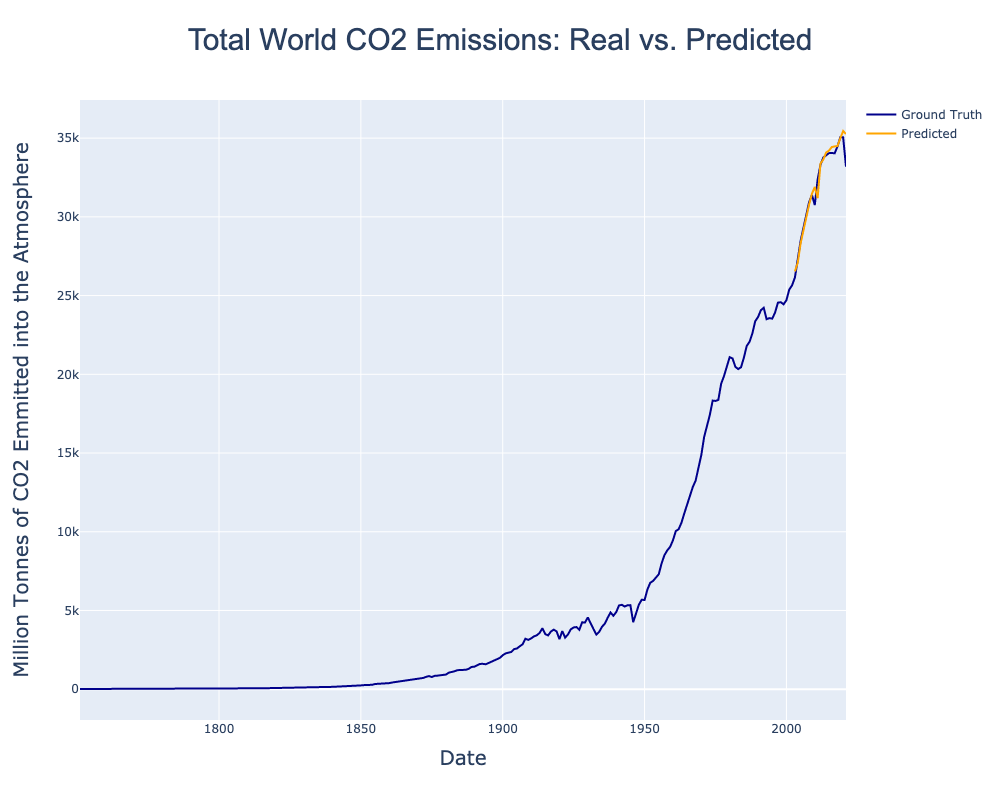

In [19]:
# Plotting the Results
fig = go.Figure()

fig.update_layout(
    width = 1000,
    height = 800,
    title = dict(
        text = 'Total World CO2 Emissions: Real vs. Predicted',
        font = dict(
            family = 'Arial',
            size = 30
        ),
        x = 0.5
    )
)

fig.update_xaxes(
    title_text = 'Date',
    title_font = {'size': 20}
)

fig.update_yaxes(
    title_text = 'Million Tonnes of CO2 Emmitted into the Atmosphere',
    title_font = {'size': 20}
)

fig.add_trace(
    go.Scatter(
        x = result['date'],
        y = result['co2'],
        mode = 'lines',
        name = 'Ground Truth',
        marker = dict(
            color = 'darkblue',
            size = 15
        )
    )
)

fig.add_trace(
    go.Scatter(
        x = result['date'],
        y = result['co2_pred'],
        mode = 'lines',
        name = 'Predicted',
        marker = dict(
            color = 'orange',
            size = 15
        )
    )
)

fig.show('png')

## Performance of the Model in the Test Set: Mean Absolute Percentage Error (MAPE)

In [20]:
# Function for computing MAPE

def compute_mape(df, date_ini):
    # Input: dataframe with columns 'date', 'co2' and 'co2_pred', and date_ini.
    errors = []
    for ii in range(df.index[df.date == date_ini].tolist()[0],len(df)):
        date = df.iloc[ii]['date']
        y_true = df.iloc[ii]['co2']
        y_pred = df.iloc[ii]['co2_pred']
        mape = mean_absolute_error([y_true], [y_pred])/y_true
        errors.append([date, 100*mape])
    return errors

In [21]:
date_ini = result.loc[(len(df)-len(scaled_predicted)), 'date']
errors = compute_mape(result, date_ini)

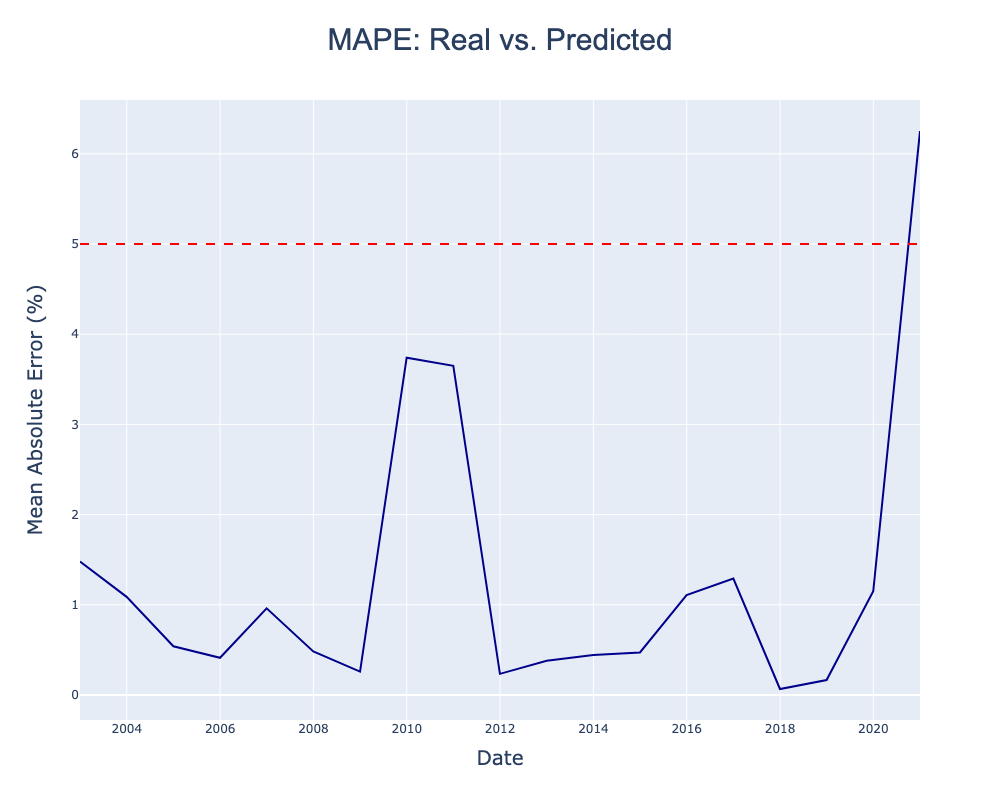

In [22]:
# MAPE Graph
x, y = zip(*errors)

fig = go.Figure()

fig.update_layout(
    width = 1000,
    height = 800,
    title = dict(
        text = 'MAPE: Real vs. Predicted',
        font = dict(
            family = 'Arial',
            size = 30
        ),
        x = 0.5
    )
)

fig.update_xaxes(
    title_text = 'Date',
    title_font = {'size': 20}
)

fig.update_yaxes(
    title_text = 'Mean Absolute Error (%)',
    title_font = {'size': 20}
)

fig.add_trace(
    go.Scatter(
        x = x,
        y = y,
        mode = 'lines',
        marker = dict(
            color = 'darkblue',
            size = 15
        )
    )
)

fig.add_hline(y=5,
                line_width = 2,
                line_color = 'red',
                line_dash = 'dash'
)

fig.show('png')

**Comments:**
- The MAPE stays below 2% on almost all testing points
- The greatest error occurs on the last point, that corresponds to the COVID-19 pandemic (which is something that the model cannot expect)
- It shows a good trend into future predictions

## Save the Model to Import Later

In [23]:
# Create a Folder and Save the Best Model
directory = 'best_lstm_model_tuned'
parent_dir = os.path.abspath(os.getcwd())
path = os.path.join(parent_dir, directory)
os.mkdir(path)
best_model.save('best_lstm_model_tuned/best_lstm.h5')

In [29]:
# Scaled Predicted Values (These Data is going to be used as a starting point in the comparison)
predicted

array([[1.0810298],
       [1.1033834],
       [1.1536444],
       [1.1886206],
       [1.2179981],
       [1.2541158],
       [1.2821345],
       [1.2994323],
       [1.2704215],
       [1.3599081],
       [1.3705541],
       [1.3886181],
       [1.3935411],
       [1.4027524],
       [1.4044411],
       [1.4052532],
       [1.4258372],
       [1.4443076],
       [1.436478 ]], dtype=float32)